## SimCLR & AbMIL

- This was the model giving us the best performance. 
- We trained the SimCLR for 150 epochs to minimise the contrastive loss to approach images from the label and repel the ones coming from other labels. We remarked that using the negative pair is crucial for the success of the method. Otherwise, the network can collapse
and output a constant vector for all images which does indeed minimize our the contrastive loss. However, the
choice of the negative and positive examples in our case is challenging. Because we are using images of miligant cases where the are not necessarily tumor in all of them 

- We used the SimCLR as a better feature extractor for our network mixed with AbMIL to perform MIL and predict the labels


In [1]:
import warnings
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

### 1- SimCLR backbone to generate feature vectors

In [2]:
from simclr import SimCLR

In [3]:
# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

embeddings_dim = 256
projection_dim = 512

# Define the backbone as a ResNet18
encoder = models.resnet18(pretrained=True)
num_features = encoder.fc.in_features
encoder.fc = nn.Linear(num_features, embeddings_dim)

# Define the projection head as two linear layers with ReLU activation
head = nn.Sequential(
    nn.Linear(embeddings_dim, 256),
    nn.ReLU(),
    nn.Linear(256, projection_dim)
)

nb_channels, nb_rows, nb_columns = 3, 190, 190

model = SimCLR(encoder, head, nb_channels, nb_rows, nb_columns)
model.load_state_dict(torch.load("./models/Simclr_epoch_150.pth"))
model.to(device)
model.eval()

SimCLR(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

## 2- Patient Class:

In [10]:
from Patient import Patient, PatientDataset
from utils import preprocess_metadata
from AbMIL import PatientAMIL

In [5]:
train_set_meta, test_set_meta = preprocess_metadata()
train_dataset = []
test_dataset = []

# Load train patients
for patient_id in train_set_meta.index:
    patient_info = train_set_meta.loc[patient_id]
    images_path = os.path.join('../dataset/trainset', patient_id)
    label = patient_info['LABEL']
    patient = Patient(ID=patient_id,
                      age=patient_info['AGE'],
                      gender=patient_info['GENDER'],
                      lymph_count=patient_info['LYMPH_COUNT'],
                      images_path=images_path,
                      label=label,
                      model=model)  
    train_dataset.append(patient)

# Load test patients
for patient_id in test_set_meta.index:
    patient_info = test_set_meta.loc[patient_id]
    images_path = os.path.join('../dataset/testset', patient_id)
    patient = Patient(ID=patient_id,
                      age=patient_info['AGE'],
                      gender=patient_info['GENDER'],
                      lymph_count=patient_info['LYMPH_COUNT'],
                      images_path=images_path,
                      model=model)  
    test_dataset.append(patient)

# Extract features or load features from CSV and save features to CSV
for dataset in [train_dataset, test_dataset]:
    for patient in dataset:
        patient.extract_features()

# Print the number of train/test patients
print(f"Number of train patients: {len(train_dataset)}")
print(f"Number of test patients: {len(test_dataset)}")

Number of train patients: 163
Number of test patients: 42


In [16]:
train_data = []
for patient in train_dataset:
    train_data.append((patient.features, patient.label))

test_data = []
for patient in test_dataset:
    test_data.append((patient.features, patient.label))


train_data, val_data = train_test_split(train_data, test_size=0.4, random_state=42,stratify=train_set_meta['SUBGROUP'])
print(f"Number of train patients: {len(train_data)}")
print(f"Number of validation patients: {len(val_data)}")
print(f"Number of test patients: {len(test_data)}")

batch_size = 16

train_set = PatientDataset(train_data)
val_set = PatientDataset(val_data)

Number of train patients: 97
Number of validation patients: 66
Number of test patients: 42


Balanced Accuracy on the validation set: 69.70%
Best model saved.
Epoch 5, Train Loss: 0.5171463413874513
Epoch 5, Val Loss: 0.45999656888571655
Balanced Accuracy on the validation set: 77.27%
Best model saved.
Balanced Accuracy on the validation set: 83.33%
Best model saved.
Epoch 10, Train Loss: 0.40773636380632977
Epoch 10, Val Loss: 0.35004335489462723
Balanced Accuracy on the validation set: 84.85%
Best model saved.
Epoch 15, Train Loss: 0.2985131469070335
Epoch 15, Val Loss: 0.31684014179292275
Epoch 20, Train Loss: 0.22849784375014762
Epoch 20, Val Loss: 0.335123294061332
Balanced Accuracy on the validation set: 86.36%
Best model saved.


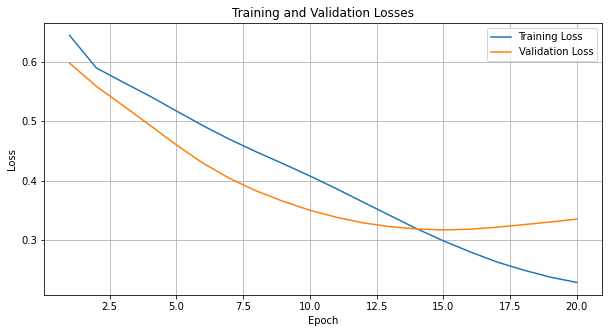

In [17]:
input_dim = 512  
hidden_dim = 256 
n_classes = 2  
model = PatientAMIL(input_dim=input_dim, hidden_dim=hidden_dim, n_classes=n_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Add a learning rate scheduler
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=3, verbose=True, min_lr=1e-7)

# Training loop
num_epochs = 20
best_balanced_accuracy = 0.0
best_model_path = 'best_model_resnet18_Abmil.pth'  # Path to save the best model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for batch_features, batch_labels in train_set:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        outputs, _, _ = model(batch_features)
        loss = criterion(outputs, batch_labels.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_losses.append(train_loss / len(train_set))
    if (epoch+1)%5 == 0:
        print(f"Epoch {epoch+1}, Train Loss: {train_loss / len(train_set)}")
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for batch_features, batch_labels in val_set:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            outputs, _, _ = model(batch_features)
            loss = criterion(outputs, batch_labels.long())
            val_loss += loss.item()
            _, predicted_val = torch.max(outputs, 1)
            total_val += batch_labels.size(0)
            correct_val += (predicted_val == batch_labels).sum().item()

    val_losses.append(val_loss / len(val_set))
    val_accuracy = correct_val / total_val
    if (epoch+1)%5 == 0:
        print(f"Epoch {epoch+1}, Val Loss: {val_losses[-1]}")
    if val_accuracy > best_balanced_accuracy:
        best_balanced_accuracy = val_accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"Balanced Accuracy on the validation set: {100 * val_accuracy:.2f}%")
        print("Best model saved.")

    lr_scheduler.step(train_losses[-1])  # Pass the last training loss for learning rate scheduler

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
best_model = PatientAMIL(input_dim=input_dim, hidden_dim=hidden_dim, n_classes=n_classes)
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)
best_model.eval()

# Generate predictions for the test set
predictions = []
with torch.no_grad():
    predictions = {}
    for patient in test_dataset:
        batch_features = torch.from_numpy(np.array(patient.features)).to(device)
        outputs, _, _ = best_model(batch_features)
        _, predicted = torch.max(outputs, 1)
        predictions[patient.ID] = predicted.item()
print(predictions)

with open('predictions.csv', 'w') as f:
    f.write("Id,Predicted\n")
    for patient_id, prediction in predictions.items():
        f.write(f"{patient_id},{prediction}\n")


{'P71': 1, 'P16': 1, 'P114': 1, 'P170': 1, 'P98': 1, 'P69': 1, 'P92': 1, 'P132': 1, 'P81': 1, 'P73': 1, 'P143': 1, 'P175': 1, 'P56': 1, 'P139': 1, 'P152': 1, 'P203': 1, 'P75': 1, 'P9': 1, 'P24': 1, 'P4': 1, 'P32': 1, 'P120': 1, 'P138': 1, 'P172': 1, 'P57': 0, 'P195': 1, 'P68': 0, 'P133': 1, 'P14': 1, 'P119': 1, 'P7': 1, 'P49': 0, 'P93': 1, 'P178': 1, 'P58': 1, 'P108': 1, 'P197': 0, 'P196': 1, 'P86': 0, 'P18': 1, 'P188': 1, 'P148': 0}


## Ablation Study 

### 1-The dimension of the hidden layer of AbMIL

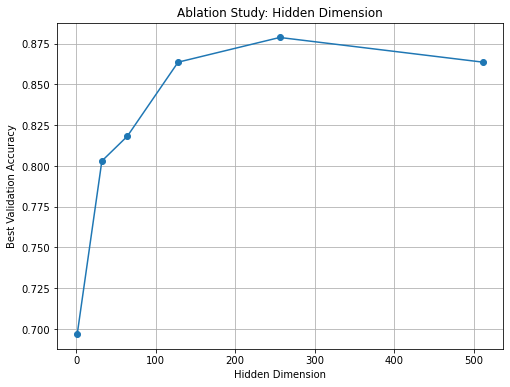

In [23]:
hidden_dims = [1, 32, 64, 128, 256, 512]

best_accuracies = []

for hidden_dim in hidden_dims:
    input_dim = 512  
    n_classes = 2  
    model = PatientAMIL(input_dim=input_dim, hidden_dim=hidden_dim, n_classes=n_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=3, verbose=True, min_lr=1e-7)

    # Training loop
    num_epochs = 20
    best_balanced_accuracy = 0.0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for batch_features, batch_labels in train_set:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            optimizer.zero_grad()
            outputs, _, _ = model(batch_features)
            loss = criterion(outputs, batch_labels.long())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for batch_features, batch_labels in val_set:
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
                outputs, _, _ = model(batch_features)
                _, predicted_val = torch.max(outputs, 1)
                total_val += batch_labels.size(0)
                correct_val += (predicted_val == batch_labels).sum().item()

        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)
        if val_accuracy > best_balanced_accuracy:
            best_balanced_accuracy = val_accuracy

        lr_scheduler.step(train_loss)  # Pass the training loss for learning rate scheduler

    best_accuracies.append(best_balanced_accuracy)

# Plotting the best validation accuracies for each model
plt.figure(figsize=(8, 6))
plt.plot(hidden_dims, best_accuracies, marker='o')
plt.xlabel('Hidden Dimension')
plt.ylabel('Best Validation Accuracy')
plt.title('Ablation Study: Hidden Dimension')
plt.grid(True)
plt.show()

### 2-The ratio de validation split

split_ratio: 0.2
Number of train patients: 130
Number of validation patients: 33
Number of test patients: 42
split_ratio: 0.3
Number of train patients: 114
Number of validation patients: 49
Number of test patients: 42
split_ratio: 0.4
Number of train patients: 97
Number of validation patients: 66
Number of test patients: 42
split_ratio: 0.5
Number of train patients: 81
Number of validation patients: 82
Number of test patients: 42


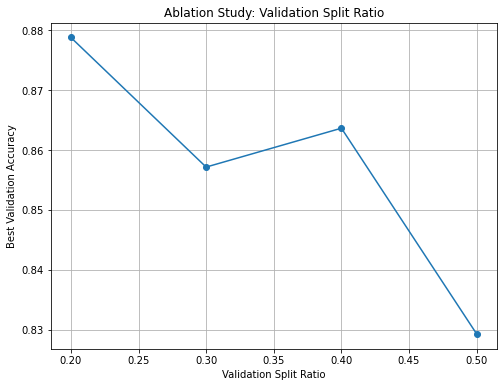

In [46]:
# Define the range of validation split ratios to test
validation_splits = [0.2, 0.3, 0.4, 0.5]

best_accuracies = []

for split_ratio in validation_splits:
    train_data = []
    for patient in train_dataset:
        train_data.append((patient.features, patient.label))

    test_data = []
    for patient in test_dataset:
        test_data.append((patient.features, patient.label))
    train_data, val_data = train_test_split(train_data, test_size=split_ratio, random_state=42, stratify=train_set_meta['SUBGROUP'])
    print(f"split_ratio: {split_ratio}")
    print(f"Number of train patients: {len(train_data)}")
    print(f"Number of validation patients: {len(val_data)}")
    print(f"Number of test patients: {len(test_data)}")

    # Define datasets and data loaders
    batch_size = 16

    train_set = PatientDataset(train_data)
    val_set = PatientDataset(val_data)

    input_dim = 512  
    hidden_dim = 256 
    n_classes = 2  
    model = PatientAMIL(input_dim=input_dim, hidden_dim=hidden_dim, n_classes=n_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Add a learning rate scheduler
    lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=3, verbose=True, min_lr=1e-7)

    # Training loop
    num_epochs = 20
    best_balanced_accuracy = 0.0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for batch_features, batch_labels in train_set:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            optimizer.zero_grad()
            outputs, _, _ = model(batch_features)
            loss = criterion(outputs, batch_labels.long())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for batch_features, batch_labels in val_set:
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
                outputs, _, _ = model(batch_features)
                _, predicted_val = torch.max(outputs, 1)
                total_val += batch_labels.size(0)
                correct_val += (predicted_val == batch_labels).sum().item()

        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)
        if val_accuracy > best_balanced_accuracy:
            best_balanced_accuracy = val_accuracy

        lr_scheduler.step(train_loss)  # Pass the training loss for learning rate scheduler

    best_accuracies.append(best_balanced_accuracy)

# Plotting the best validation accuracies for each validation split ratio
plt.figure(figsize=(8, 6))
plt.plot(validation_splits, best_accuracies, marker='o')
plt.xlabel('Validation Split Ratio')
plt.ylabel('Best Validation Accuracy')
plt.title('Ablation Study: Validation Split Ratio')
plt.grid(True)
plt.show()

split_ratio: 0.2
Number of train patients: 130
Number of validation patients: 33
Number of test patients: 42
split_ratio: 0.3
Number of train patients: 114
Number of validation patients: 49
Number of test patients: 42
split_ratio: 0.4
Number of train patients: 97
Number of validation patients: 66
Number of test patients: 42
split_ratio: 0.5
Number of train patients: 81
Number of validation patients: 82
Number of test patients: 42


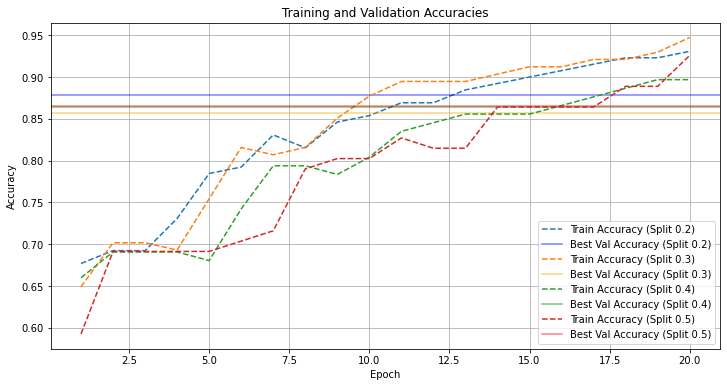

In [48]:
validation_splits = [0.2, 0.3, 0.4, 0.5]
colors = ['blue', 'orange', 'green', 'red']
best_val_accuracies = []
train_accuracies = []

for split_ratio in validation_splits:
    # Split the data into train and validation sets
    train_data = []
    for patient in train_dataset:
        train_data.append((patient.features, patient.label))

    test_data = []
    for patient in test_dataset:
        test_data.append((patient.features, patient.label))
    train_data, val_data = train_test_split(train_data, test_size=split_ratio, random_state=42, stratify=train_set_meta['SUBGROUP'])
    print(f"split_ratio: {split_ratio}")
    print(f"Number of train patients: {len(train_data)}")
    print(f"Number of validation patients: {len(val_data)}")
    print(f"Number of test patients: {len(test_data)}")

    # Define datasets and data loaders
    batch_size = 16

    train_set = PatientDataset(train_data)
    val_set = PatientDataset(val_data)

    input_dim = 512  
    hidden_dim = 256 
    n_classes = 2  
    model = PatientAMIL(input_dim=input_dim, hidden_dim=hidden_dim, n_classes=n_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Add a learning rate scheduler
    lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=3, verbose=True, min_lr=1e-7)

    # Training loop
    num_epochs = 20
    best_val_accuracy = 0.0
    train_accuracies_split = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_features, batch_labels in train_set:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            optimizer.zero_grad()
            outputs, _, _ = model(batch_features)
            loss = criterion(outputs, batch_labels.long())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted_train = torch.max(outputs, 1)
            total_train += batch_labels.size(0)
            correct_train += (predicted_train == batch_labels).sum().item()

        train_accuracy = correct_train / total_train
        train_accuracies_split.append(train_accuracy)

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for batch_features, batch_labels in val_set:
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
                outputs, _, _ = model(batch_features)
                _, predicted_val = torch.max(outputs, 1)
                total_val += batch_labels.size(0)
                correct_val += (predicted_val == batch_labels).sum().item()

        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy

        lr_scheduler.step(train_loss)  # Pass the training loss for learning rate scheduler

    best_val_accuracies.append(best_val_accuracy)
    train_accuracies.append(train_accuracies_split)

# Plotting the best validation accuracies and training accuracies for each validation split ratio
plt.figure(figsize=(12, 6))
for i, split_ratio in enumerate(validation_splits):
    plt.plot(range(1, num_epochs + 1), train_accuracies[i], label=f'Train Accuracy (Split {split_ratio})', linestyle='--')
    plt.axhline(y=best_val_accuracies[i], c=colors[i], alpha=0.5, linestyle='-', label=f'Best Val Accuracy (Split {split_ratio})')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.grid(True)
plt.show()

split_ratio: 0.2
Number of train patients: 130
Number of validation patients: 33
Number of test patients: 42


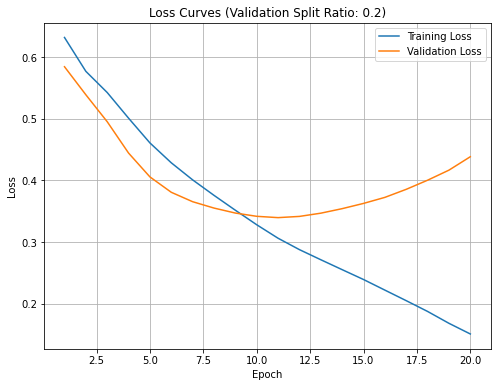

split_ratio: 0.3
Number of train patients: 114
Number of validation patients: 49
Number of test patients: 42


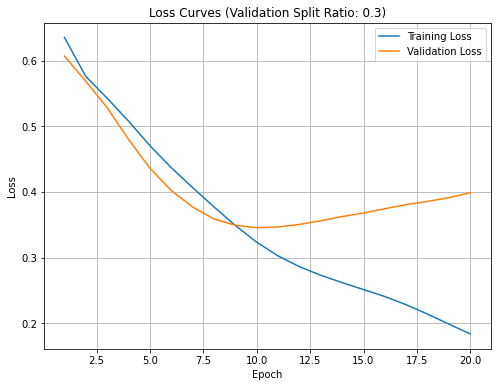

split_ratio: 0.4
Number of train patients: 97
Number of validation patients: 66
Number of test patients: 42


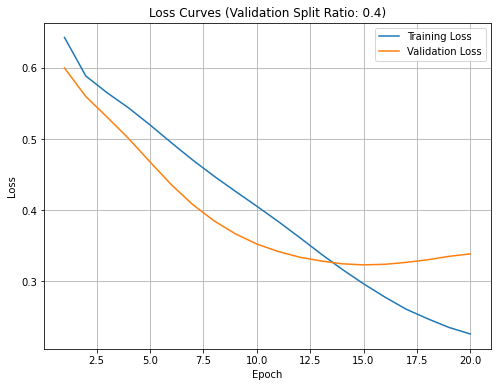

split_ratio: 0.5
Number of train patients: 81
Number of validation patients: 82
Number of test patients: 42


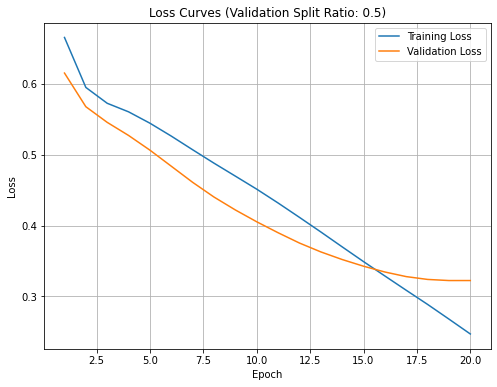

In [51]:
validation_splits = [0.2, 0.3, 0.4, 0.5]

for split_ratio in validation_splits:
    train_data = []
    for patient in train_dataset:
        train_data.append((patient.features, patient.label))

    test_data = []
    for patient in test_dataset:
        test_data.append((patient.features, patient.label))
    train_data, val_data = train_test_split(train_data, test_size=split_ratio, random_state=42, stratify=train_set_meta['SUBGROUP'])
    print(f"split_ratio: {split_ratio}")
    print(f"Number of train patients: {len(train_data)}")
    print(f"Number of validation patients: {len(val_data)}")
    print(f"Number of test patients: {len(test_data)}")

    batch_size = 16

    train_set = PatientDataset(train_data)
    val_set = PatientDataset(val_data)

    input_dim = 512  
    hidden_dim = 256 
    n_classes = 2  
    model = PatientAMIL(input_dim=input_dim, hidden_dim=hidden_dim, n_classes=n_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Add a learning rate scheduler
    lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=3, verbose=True, min_lr=1e-7)

    # Training loop
    num_epochs = 20
    best_val_accuracy = 0.0
    train_losses = []
    val_losses = []

    train_accuracies = []
    best_val_accuracies = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_features, batch_labels in train_set:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            optimizer.zero_grad()
            outputs, _, _ = model(batch_features)
            loss = criterion(outputs, batch_labels.long())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted_train = torch.max(outputs, 1)
            total_train += batch_labels.size(0)
            correct_train += (predicted_train == batch_labels).sum().item()

        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss / len(train_set))

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for batch_features, batch_labels in val_set:
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
                outputs, _, _ = model(batch_features)
                loss = criterion(outputs, batch_labels.long())
                val_loss += loss.item()
                _, predicted_val = torch.max(outputs, 1)
                total_val += batch_labels.size(0)
                correct_val += (predicted_val == batch_labels).sum().item()

        val_losses.append(val_loss / len(val_set))
        val_accuracy = correct_val / total_val
        best_val_accuracies.append(val_accuracy)

        lr_scheduler.step(train_losses[-1])  # Pass the last training loss for learning rate scheduler

    # Plotting the loss curves
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss Curves (Validation Split Ratio: {split_ratio})')
    plt.legend()
    plt.grid(True)
    plt.show()

### 3- Ablation Study : Optimizers

The experiements were averaged on 5 run-times and we compared 4 optimizers : Adam , SGD, Adagrad, Adadelta en termes de stabilité et performance

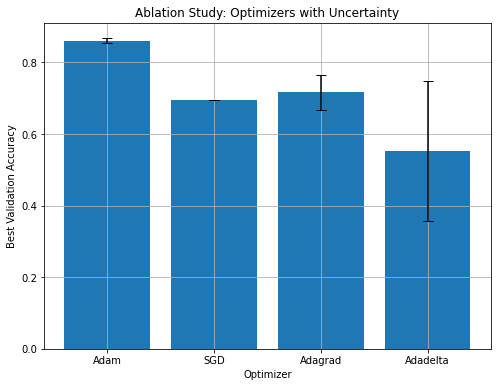

In [58]:
import torch.optim as optim
import random
# Define the optimizers to test
optimizers = {
    'Adam': optim.Adam,
    'SGD': optim.SGD,
    'Adagrad': optim.Adagrad,
    'Adadelta': optim.Adadelta
}

# Initialize a dictionary to store the balanced accuracies for each optimizer
accuracies_dict = {optimizer_name: [] for optimizer_name in optimizers}

# Define the number of runs
num_runs = 5

# Loop over each optimizer
for optimizer_name, optimizer_class in optimizers.items():
    # Initialize the list to store the balanced accuracies for this optimizer
    balanced_accuracies = []
    
    for run in range(num_runs):
        
        train_data = []
        for patient in train_dataset:
            train_data.append((patient.features, patient.label))

        test_data = []
        for patient in test_dataset:
            test_data.append((patient.features, patient.label))
        train_data, val_data = train_test_split(train_data, test_size=split_ratio, random_state=random.randint(0, 42), stratify=train_set_meta['SUBGROUP'])
        model = PatientAMIL(input_dim=input_dim, hidden_dim=hidden_dim, n_classes=n_classes)
        model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optimizer_class(model.parameters(), lr=0.0001)
        lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=3, verbose=True, min_lr=1e-7)
        
        # Initialize other variables
        best_balanced_accuracy = 0.0
        
        # Training loop
        for epoch in range(num_epochs):
            model.train()
            train_loss = 0.0

            for batch_features, batch_labels in train_set:
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
                optimizer.zero_grad()
                outputs, _, _ = model(batch_features)
                loss = criterion(outputs, batch_labels.long())
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # Validation
            model.eval()
            correct_val = 0
            total_val = 0
            with torch.no_grad():
                for batch_features, batch_labels in val_set:
                    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
                    outputs, _, _ = model(batch_features)
                    _, predicted_val = torch.max(outputs, 1)
                    total_val += batch_labels.size(0)
                    correct_val += (predicted_val == batch_labels).sum().item()

            val_accuracy = correct_val / total_val
            if val_accuracy > best_balanced_accuracy:
                best_balanced_accuracy = val_accuracy

            lr_scheduler.step(train_loss)  # Pass the training loss for learning rate scheduler
        
        # Append the best balanced accuracy for this run to the list
        balanced_accuracies.append(best_balanced_accuracy)
    
    # Store the list of balanced accuracies for this optimizer in the dictionary
    accuracies_dict[optimizer_name] = balanced_accuracies

# Calculate the mean and standard deviation of the balanced accuracies for each optimizer
mean_accuracies = {optimizer_name: torch.tensor(balanced_accuracies).mean().item() for optimizer_name, balanced_accuracies in accuracies_dict.items()}
std_accuracies = {optimizer_name: torch.tensor(balanced_accuracies).std().item() for optimizer_name, balanced_accuracies in accuracies_dict.items()}

# Plotting the mean balanced accuracies with error bars (standard deviation) for each optimizer
plt.figure(figsize=(8, 6))
plt.bar(mean_accuracies.keys(), mean_accuracies.values(), yerr=std_accuracies.values(), capsize=5)
plt.xlabel('Optimizer')
plt.ylabel('Best Validation Accuracy')
plt.title('Ablation Study: Optimizers with Uncertainty')
plt.grid(True)
plt.show()
